In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import ast
from ipywidgets import interact, widgets, HBox, Layout

In [2]:
# date et l'heure actuelles
now = datetime.now()

# Calcule du le début de la semaine dernière (lundi)
week_start_date = now - timedelta(days=now.weekday()) - timedelta(days=7)
week_start = week_start_date.strftime('%d/%m/%Y')

# Calcule de la fin de la semaine dernière (dimanche)
week_end_date = now + timedelta(days=(-1 - now.weekday()))
week_end = week_end_date.strftime('%d/%m/%Y')

# Liste des dates de la semaine dernière (du lundi au dimanche)
week_dates = [(week_start_date + timedelta(days=i)).strftime('%d/%m/%Y') for i in range((week_end_date - week_start_date).days + 1)]

# 

# 

# CHARGEMENT DONNEES

In [3]:
# Lecture du fichier de perturbations TGV/TER
df_disruption = pd.read_csv("C:\\Users\\Kyliv\\DATA_PROJECT\\TGV_TER_PRODUCT\\Data\\TGV_TER_perturbation.csv")
# Filtrer les perturbations pour les dates de la semaine dernière
df_disruption = df_disruption[df_disruption['data_date'].isin(week_dates)]

# Lecture du fichier des véhicules de trajet TGV/TER
df_vehicle = pd.read_csv("C:\\Users\\Kyliv\\DATA_PROJECT\\TGV_TER_PRODUCT\\Data\\TGV_TER_trajet_vehicules.csv")
# Filtrer les données des véhicules pour les dates de la semaine dernière
df_vehicle = df_vehicle[df_vehicle['data_date'].isin(week_dates)]

# Lecture du fichier d'informations sur les lignes TGV/TER
df_lines = pd.read_csv("C:\\Users\\Kyliv\\DATA_PROJECT\\TGV_TER_PRODUCT\\Data\\TGV_TER_lines_info.csv")
# Supprimer les lignes du réseau NightJet
df_lines = df_lines[df_lines['network_name'] != 'NightJet']

# Lecture du fichier des résultats précédents
df_past = pd.read_csv('Resultats_rapport_2.csv', sep=",")

# 

# 

# TRANSFORMATION DES DONNEES

In [4]:
# Convertion des colonnes 'disruption_start' et 'disruption_end' en objets datetime
df_disruption['disruption_start'] = pd.to_datetime(df_disruption['disruption_start'], format='%H:%M:%S')
df_disruption['disruption_end'] = pd.to_datetime(df_disruption['disruption_end'], format='%H:%M:%S')

# Calcule de la durée de chaque perturbation
df_disruption['duration_disruption'] = df_disruption['disruption_end'] - df_disruption['disruption_start']

# Remplissage des valeurs manquantes dans la colonne 'cause_delay' avec 'Non connu'
df_disruption['cause_delay'] = df_disruption['cause_delay'].fillna('Non connu')

In [5]:
## Regroupement des causes de perturbations en plusieurs categories

# Incivilité
incivilite = [
    "Acte de vandalisme",
    "Présence d'un bagage abandonné",
    "Présence d'individus sur les voies",
    "Incendie aux abords de la voie",
    "Déclenchement du signal d'alarme",
    "Intervention des forces de l'ordre"
]
# Problèmes techniques et matériel
problemes_techniques = [
    "Défaillance de matériel",
    "Panne de signalisation",
    "Panne d'un passage à niveau",
    "Panne d'un aiguillage",
    "Défaut d'alimentation électrique",
    "Indisponibilité d'un matériel",
    "Dérangement d'une installation en gare",
    "Modification de matériel"
]
# Conditions opérationnelles
conditions_operationnelles = [
    "Régulation du trafic",
    "Réutilisation d'un train",
    "Difficultés lors de la préparation du train",
    "Prise en charge de clients en correspondance",
    "Conditions de départ non réunies",
    "Mise à quai tardive en gare origine",
    "Arrêt exceptionnel en gare",
    "Saturation des voies en gare",
    "Confirmation tardive de la voie",
    "Erreur d'itinéraire"
]    
# Conditions externes
conditions_externes = [
    "Travaux sur les voies",
    "Obstacle sur la voie",
    "Incident de circulation",
    "Incident sur un réseau ferré étranger",
    "Accident de personne",
    "Conditions météorologiques",
    "Présence d'animaux sur la voie"
]

assistance_passagers = [
    "Assistance à un voyageur malade à bord",
    "Assistance à un voyageur",
    "Affluence de voyageurs entraînant un arrêt prolongé"
]

df_disruption['group_delay'] = df_disruption['cause_delay'].apply(lambda x: 'incivilite' if x in incivilite 
                                                                 else ('problemes techniques' if x in problemes_techniques
                                                                 else ('conditions operationnelles' if x in conditions_operationnelles
                                                                 else ('conditions externes' if x in conditions_externes
                                                                 else ('assistance passagers' if x in assistance_passagers
                                                                 else x)))))

In [6]:
# Création d'une nouvelle DataFrame en supprimant les lignes en double basées sur les colonnes 'id_disruption' et 'vehicle_id'
df_disruption_unique = df_disruption.drop_duplicates(['id_disruption','vehicle_id'])

In [7]:
# Fusion des DataFrames
df_merge_inter = pd.merge(df_vehicle, df_disruption.drop(['data_date','train_type'],axis=1), on=['vehicle_id','id_disruption'], how='left')
df_merge = pd.merge(df_merge_inter, df_lines.drop('train_type', axis=1), on='route_id', how='left')

# Suppression des doublons de la colonne 'vehicle_id' dans la DataFrame fusionnée
df_merge = df_merge[~df_merge.duplicated(subset=['vehicle_id'], keep='first')]


# 

# 

# ANALYSE GENERALE DES PERTURBATIONS

### NOMBRE DE PERTURBATION SUR LA SEMAINE

In [8]:
# Calcule du nombre de perturbtaion 
nb_disruption = df_vehicle['id_disruption'].nunique()
print(f"nombre de perturbation : {nb_disruption}")

# Comparaison entre le nombre de perturbations de la semaine passée et celui de la semaine actuelle
nb_disruption_past = df_past['nb_disruption'][len(df_past)-1]
comparaison = "de plus" if nb_disruption_past < nb_disruption else "de moins"
print(f"C'est {abs(nb_disruption_past - nb_disruption)} {comparaison} que la semaine passée")

nombre de perturbation : 7040
C'est 111 de moins que la semaine passée


In [9]:
# Calcul du nombre de trajet sur la semaine
nb_vehicle_journeys = df_vehicle['vehicle_id'].nunique()
print(f"nombre de trajet sur la semaine du {week_start} au {week_end} : {nb_vehicle_journeys}")

nombre de trajet sur la semaine du 27/05/2024 au 02/06/2024 : 55662


In [10]:
# Calcul du pourcentage de trajets perturbés sur la semaine actuelle
per_disrupted = nb_disruption/nb_vehicle_journeys*100
print(f"pourcentage de trajet pertubé sur la semaine du {week_start} au {week_end} : {round(per_disrupted,2)}%")

# Comparaison entre le pourcentage de trajets perturbés de la semaine passée et celui de la semaine actuelle
per_disrupted_past = df_past['per_disrupted'][len(df_past)-1]
comparaison = ["de plus", "augmentation"] if per_disrupted_past < per_disrupted else ["de moins", 'diminution']
print(f"C'est {abs(per_disrupted_past - per_disrupted):.2f}% {comparaison[0]} que la semaine passée. Soit une {comparaison[1]} de {abs((per_disrupted_past-per_disrupted)/per_disrupted*100):.2f}%")

pourcentage de trajet pertubé sur la semaine du 27/05/2024 au 02/06/2024 : 12.65%
C'est 0.22% de moins que la semaine passée. Soit une diminution de 1.75%


In [11]:
nb_disruption_daily = df_vehicle.groupby('data_date')['id_disruption'].nunique()
nb_vehicle_journeys_daily = df_vehicle.groupby('data_date')['vehicle_id'].nunique()

per_disrupted_daily = nb_disruption_daily/nb_vehicle_journeys_daily*100

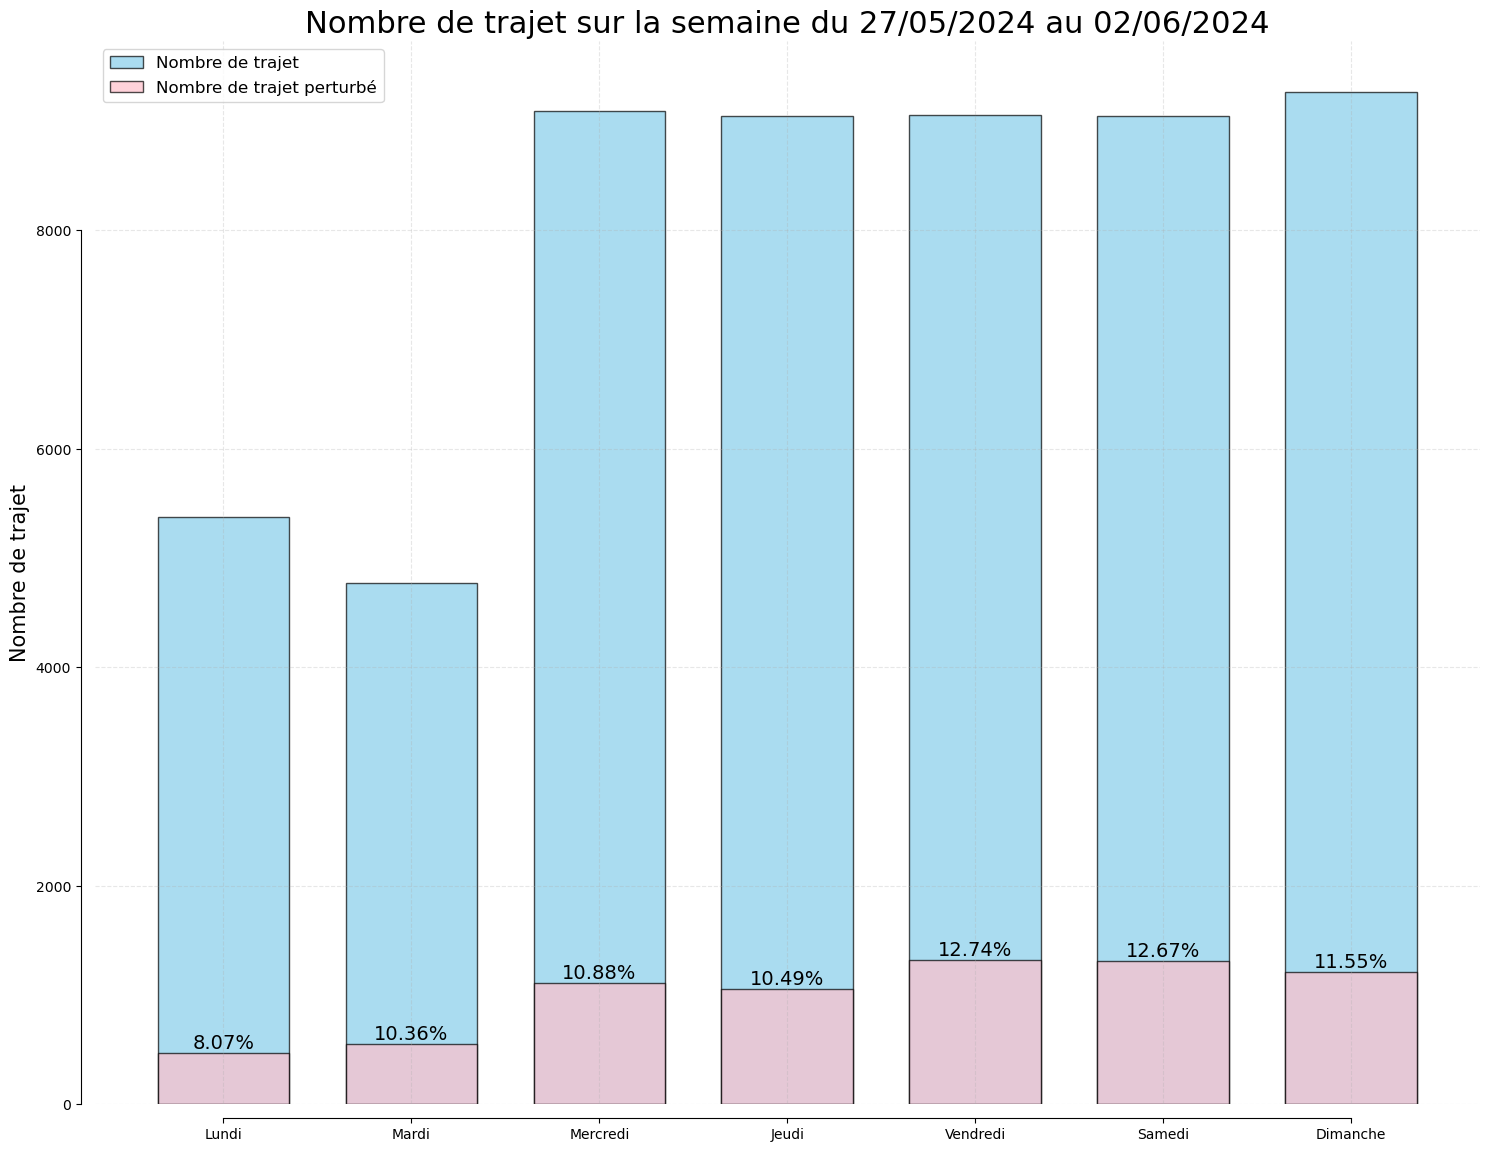

In [12]:
days_name = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

plt.figure(figsize=(15, 12))
plt.bar(nb_vehicle_journeys_daily.index, nb_vehicle_journeys_daily.values, color='skyblue', edgecolor='black', width=0.7, alpha=0.7, label= 'Nombre de trajet')
plt.bar(nb_disruption_daily.index, nb_disruption_daily.values, color='pink', edgecolor='black', width=0.7, alpha=0.7, label= 'Nombre de trajet perturbé')

for i in range(len(nb_vehicle_journeys_daily)):
    plt.text(nb_vehicle_journeys_daily.index[i], nb_disruption_daily.values[i], f'{nb_disruption_daily.values[i]/(nb_vehicle_journeys_daily.values[i] + nb_disruption_daily.values[i])*100:.2f}%', ha='center', va='bottom', fontsize=14)
    
plt.title(f'Nombre de trajet sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de trajet', fontsize=15)
plt.xticks(nb_disruption_daily.index,days_name , rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.legend(fontsize='12')


plt.show()

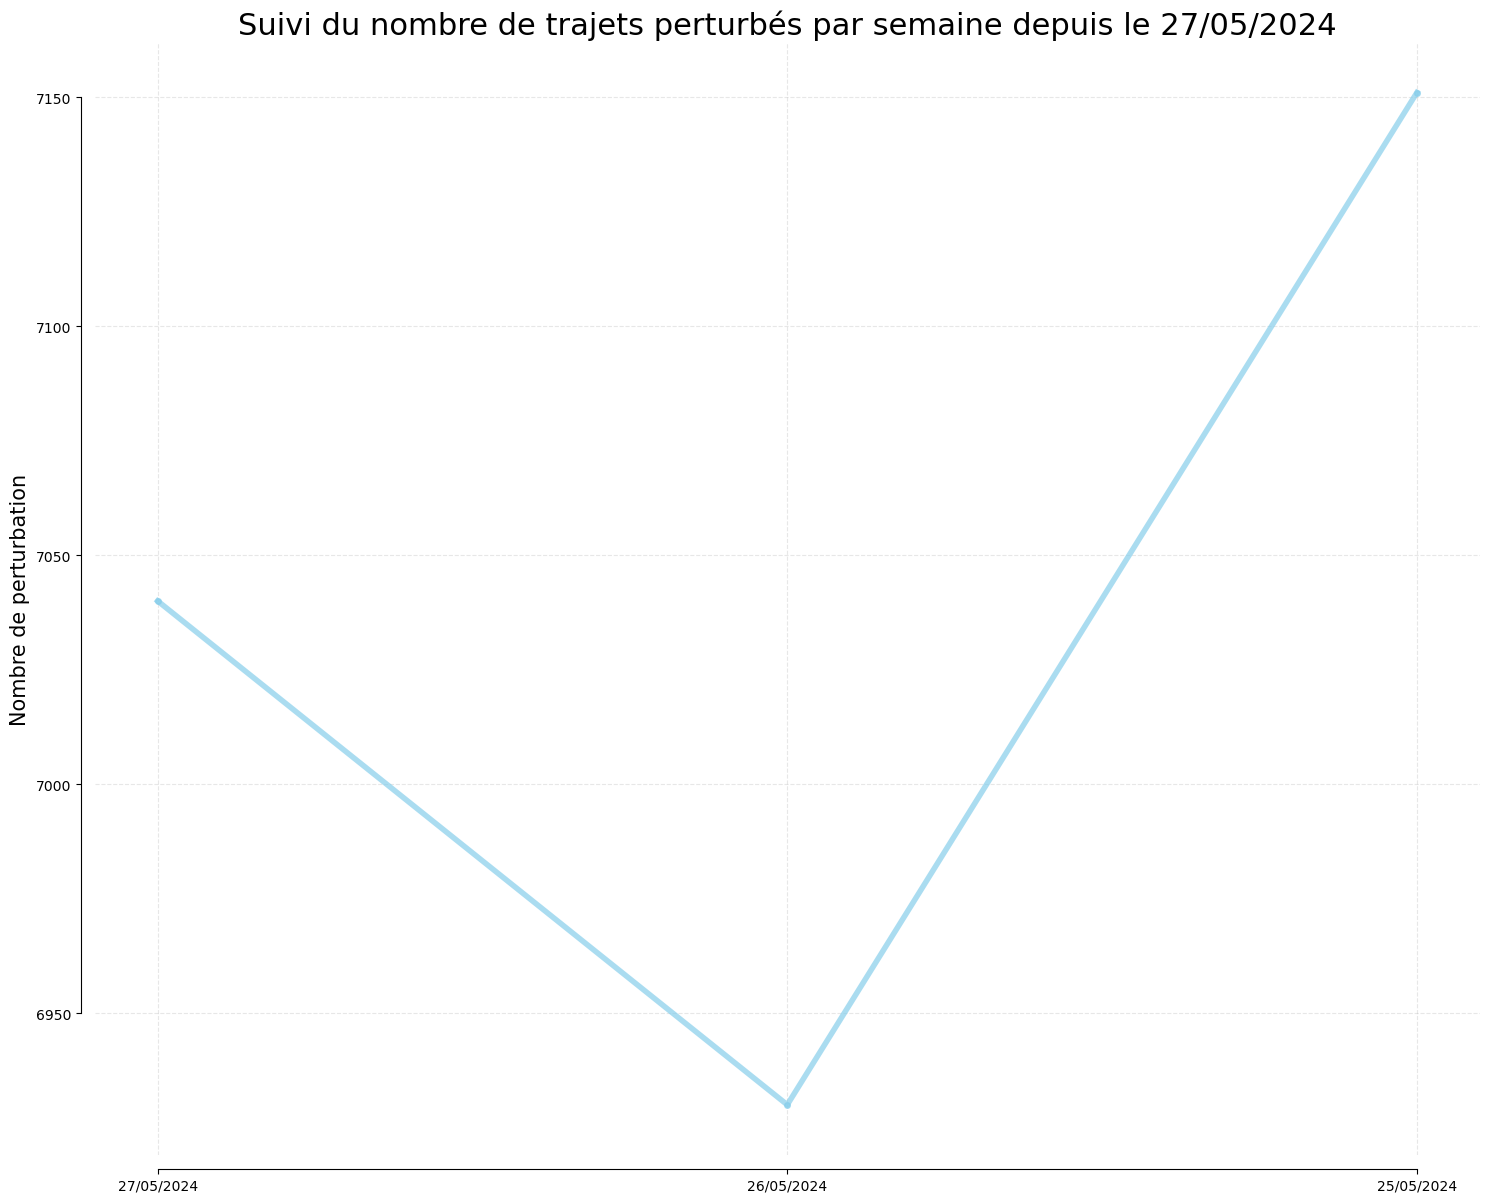

In [13]:
first_data_date = df_past['data_date'][0]

plt.figure(figsize=(15, 12))
plt.plot(df_past['data_date'], df_past['nb_disruption'], color='skyblue', lw=4, alpha=0.7, marker='o', markersize=4)

plt.title(f'Suivi du nombre de trajets perturbés par semaine depuis le {first_data_date}', fontsize=22)
plt.ylabel('Nombre de perturbation', fontsize=15)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)


plt.show()

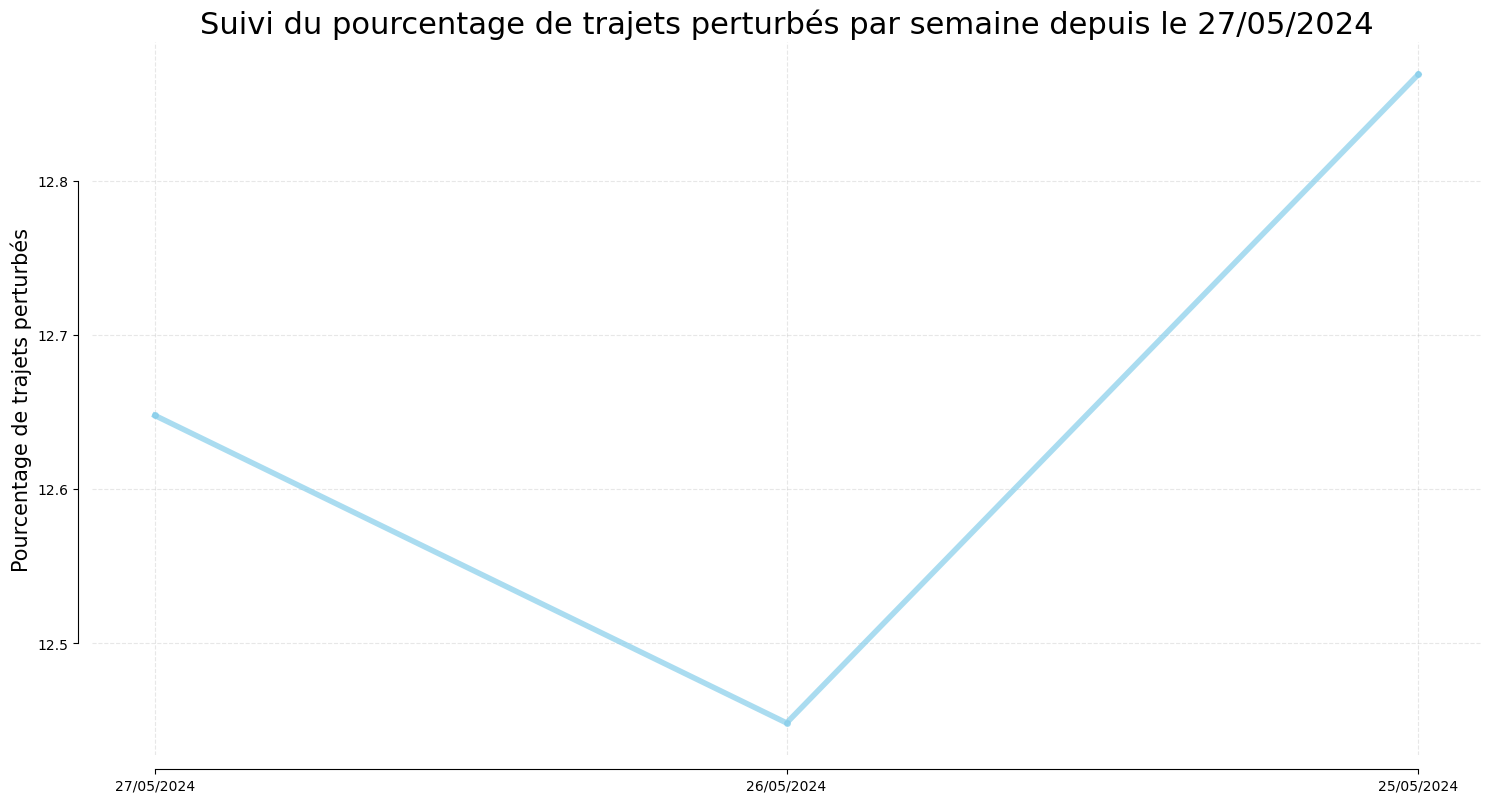

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(df_past['data_date'], df_past['per_disrupted'], color='skyblue', lw=4, alpha=0.7, marker='o', markersize=4)

plt.title(f'Suivi du pourcentage de trajets perturbés par semaine depuis le {first_data_date}', fontsize=22)
plt.ylabel('Pourcentage de trajets perturbés', fontsize=15)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)


plt.show()

Ces graphiques offrent une vue dynamique de l'évolution hebdomadaire du nombre et du pourcentage de trajets perturbés, fournissant ainsi une analyse approfondie de la fiabilité du système de transport.


Ces graphiques peuvent servir d'indices de la gestion des transports dans le temps en fournissant des informations cruciales sur la fiabilité et l'efficacité du système de transport. En effet, il permet :


La surveillance de la performance : En suivant l'évolution du nombre et du pourcentage de trajets perturbés au fil du temps, les autorités de transport peuvent évaluer la performance globale du réseau. Des variations significatives pourraient indiquer des problèmes opérationnels ou des défis persistants à résoudre.



l'evaluation des interventions : Les gestionnaires peuvent évaluer l'efficacité des interventions et des améliorations apportées au système de transport en surveillant l'impact sur le nombre et le pourcentage de trajets perturbés. Cela permet d'identifier les stratégies qui ont réussi à réduire les perturbations et celles qui nécessitent des ajustements supplémentaires.

# 

###  TEMPS MOYEN DES PERTURBATIONS

In [15]:
# Calcul de la moyenne du temps de perturbation en minutes
mean_time_disruption_minutes = int((df_disruption['duration_disruption'].dt.total_seconds()/(60)).mean())
print(f"Le temps moyen des perturbations sur la semaine du {week_start} au {week_end} a été de : {mean_time_disruption_minutes//60} heure et {mean_time_disruption_minutes%60} minutes")

# Comparaison
mean_time_disruption_minutes_past = df_past['mean_time_disruption_minutes'][len(df_past)-1]
comparaison = ["de plus", "augmentation"] if mean_time_disruption_minutes_past < mean_time_disruption_minutes else ["de moins", 'diminution']
print(f"C'est {abs(mean_time_disruption_minutes_past - mean_time_disruption_minutes)} minutes {comparaison[0]} que la semaine passée. Ceci représente une {comparaison[1]} de {abs((mean_time_disruption_minutes_past-mean_time_disruption_minutes)/mean_time_disruption_minutes*100):.2f}%")

Le temps moyen des perturbations sur la semaine du 27/05/2024 au 02/06/2024 a été de : 1 heure et 55 minutes
C'est 2 minutes de plus que la semaine passée. Ceci représente une augmentation de 1.74%


In [16]:
# Calcul de la durée moyenne des perturbations par jour en minutes
mean_time_disruption_minutes_daily = round(df_disruption.groupby('data_date')['duration_disruption'].mean().dt.total_seconds() / 60)

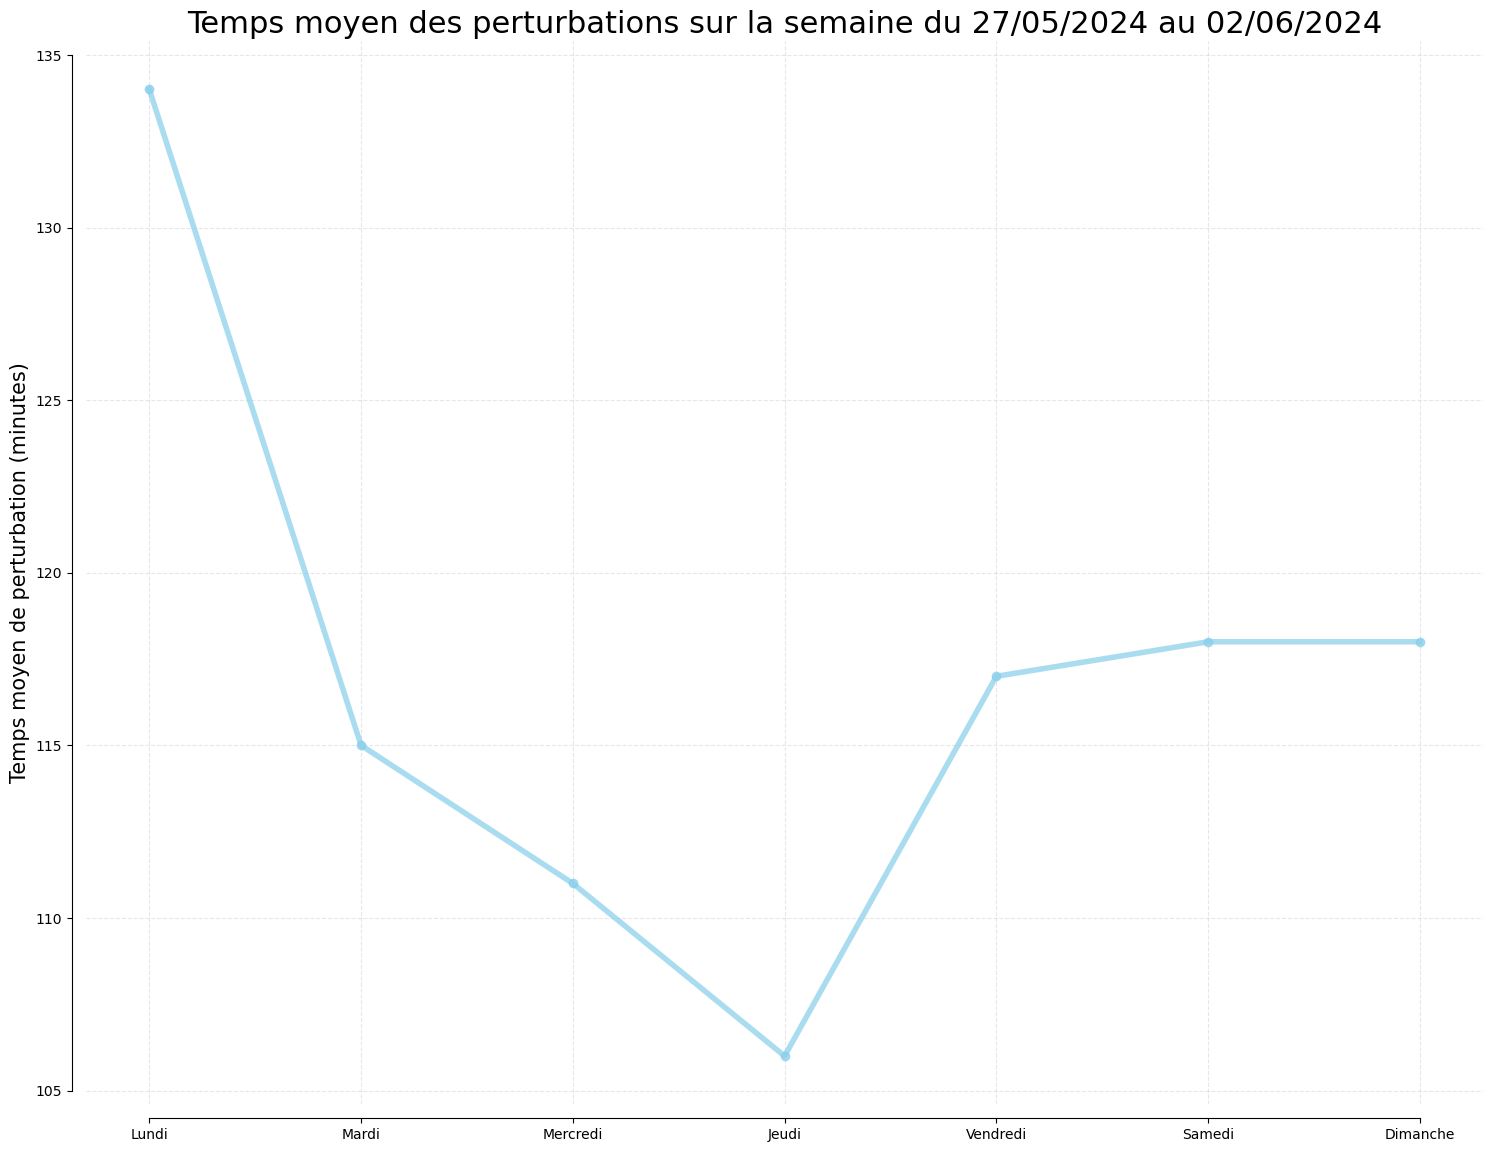

In [17]:
plt.figure(figsize=(15, 12))
plt.plot(mean_time_disruption_minutes_daily.index, mean_time_disruption_minutes_daily.values, color='skyblue', alpha=0.7, lw=4, marker='o', markersize=6)

plt.title(f'Temps moyen des perturbations sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Temps moyen de perturbation (minutes)', fontsize=15)
plt.xticks(nb_disruption_daily.index, days_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

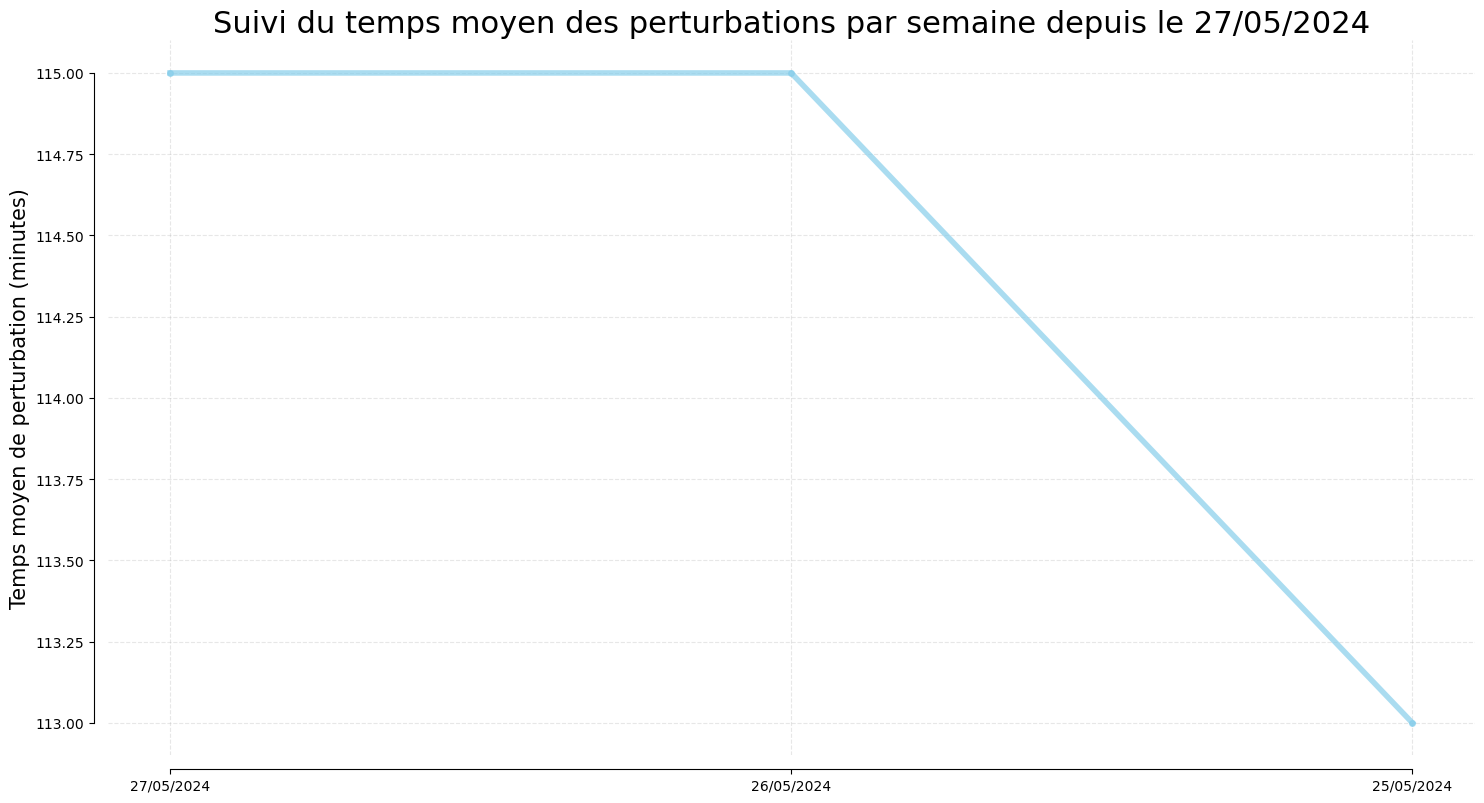

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(df_past['data_date'], df_past['mean_time_disruption_minutes'], color='skyblue', lw=4, alpha=0.7, marker='o', markersize=4)

plt.title(f'Suivi du temps moyen des perturbations par semaine depuis le {first_data_date}', fontsize=22)
plt.ylabel('Temps moyen de perturbation (minutes)', fontsize=15)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)


plt.show()

Ce graphique offre une représentation dynamique de l'évolution du temps moyen des perturbations. En suivant cette métrique au fil du temps, il devient possible d'évaluer l'efficacité de la gestion des perturbations. Une diminution du temps moyen des perturbations peut indiquer une amélioration dans la gestion des incidents, suggérant ainsi des progrès dans la résolution rapide des problèmes et une meilleure réactivité du système de transport aux situations perturbatrices. Par conséquent, ce graphique joue un rôle crucial dans la surveillance de la performance opérationnelle.

# 

### RETARD CAUSE PAR LES PERTURBATIONS

In [19]:
# Calcul du retard total en heures sur l'ensemble du réseau pour la semaine actuelle
total_delay = int(df_disruption['arrival_delay'].sum() / 60)
# Calcul de la moyenne du retard par perturbation en minutes
mean_delay_by_disruption = round(total_delay / nb_disruption * 60)

# Comparaison
total_delay_past = df_past['total_delay'][len(df_past)-1]
mean_delay_by_disruption_past = round(total_delay_past/nb_disruption_past*60)

comparaison = ["de plus", "augmentation"] if mean_delay_by_disruption_past < mean_delay_by_disruption else ["de moins", 'diminution']
print(f"Ces perturbations ont causé durant  la semaine du {week_start} au {week_end}: {total_delay} heures de retard cummulé sur l'ensemble du réseau.")
print(f"Soit, une moyenne d'environ {mean_delay_by_disruption} minutes de retard cummulé sur l'esemble du réseau par perturbation enregistré. C'est {abs(mean_delay_by_disruption_past-mean_delay_by_disruption)} minutes {comparaison[0]} par rapport à la semaine précédente. Ce qui represente une {comparaison[1]} de {abs((mean_delay_by_disruption_past - mean_delay_by_disruption)/mean_delay_by_disruption*100):.2f}%")

Ces perturbations ont causé durant  la semaine du 27/05/2024 au 02/06/2024: 7118 heures de retard cummulé sur l'ensemble du réseau.
Soit, une moyenne d'environ 61 minutes de retard cummulé sur l'esemble du réseau par perturbation enregistré. C'est 0 minutes de moins par rapport à la semaine précédente. Ce qui represente une diminution de 0.00%


In [20]:
# Calcul du retard total par jour en heures sur l'ensemble du réseau
total_delay_daily = round(df_disruption.groupby('data_date')['arrival_delay'].sum() / 60)
# Calcul de la moyenne du retard par perturbation par jour en minutes
mean_delay_by_disruption_daily = round(total_delay_daily / nb_disruption_daily * 60)

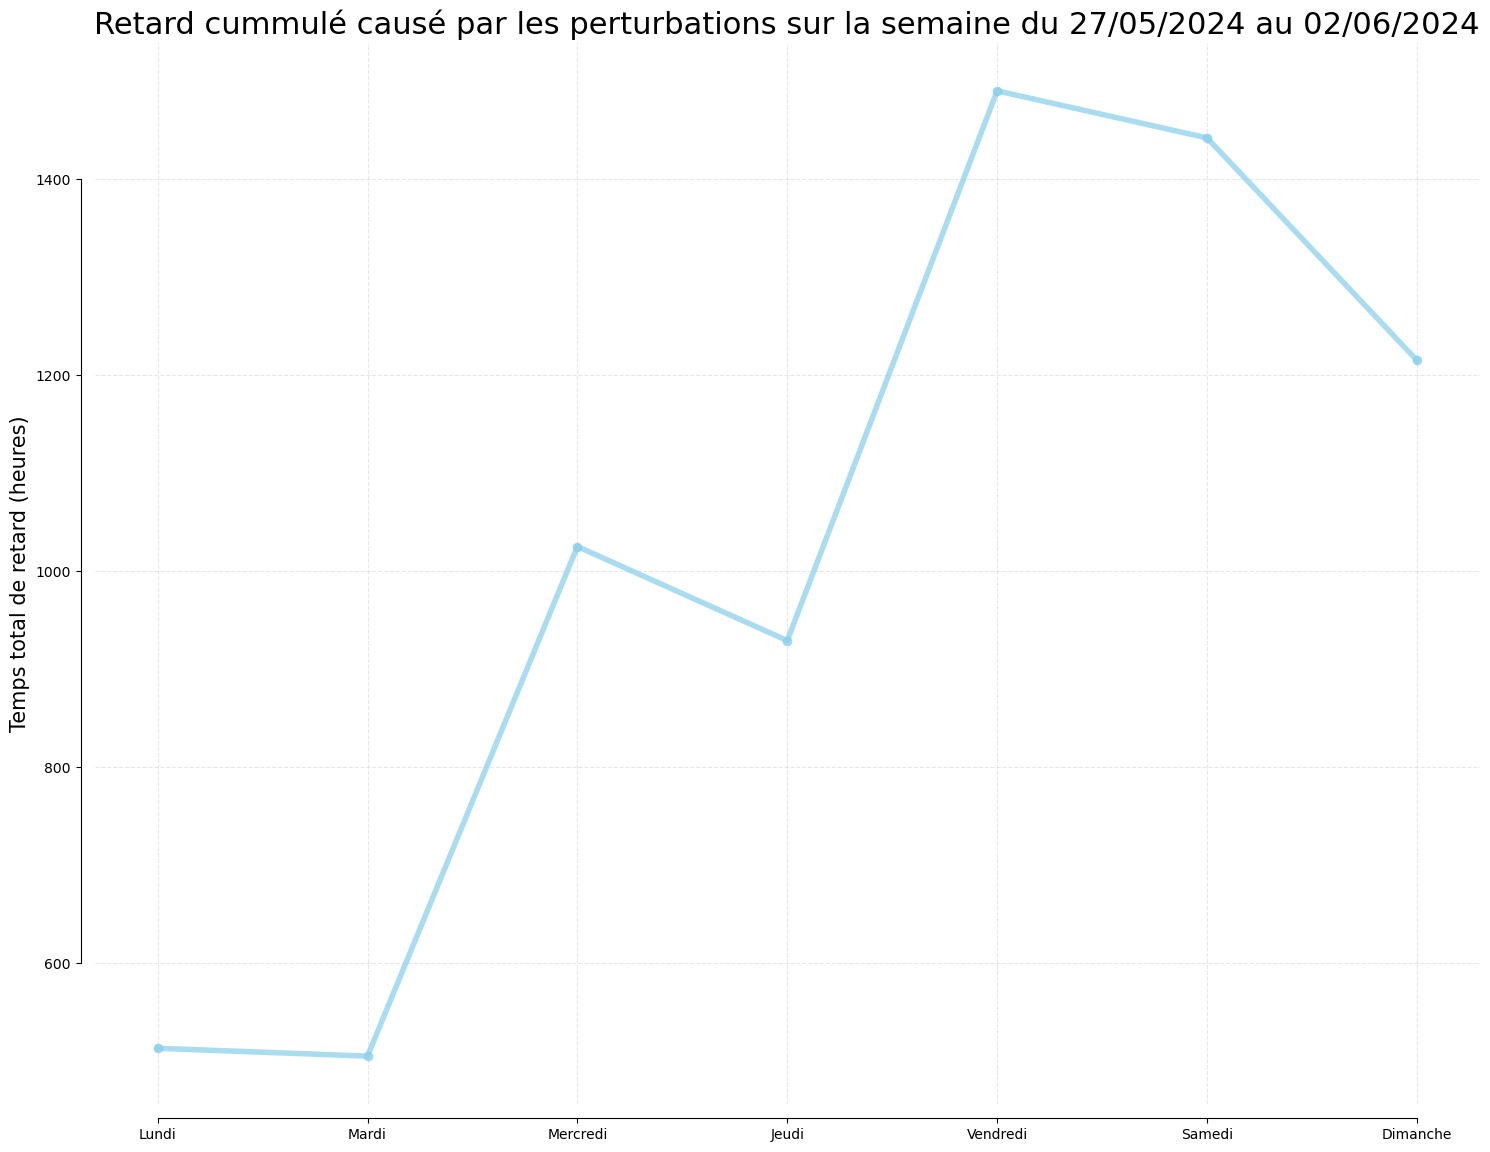

In [21]:
plt.figure(figsize=(15, 12))
plt.plot(total_delay_daily.index, total_delay_daily.values, color='skyblue', alpha=0.7, lw=4, marker='o', markersize=6)

plt.title(f'Retard cummulé causé par les perturbations sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Temps total de retard (heures)', fontsize=15)
plt.xticks(nb_disruption_daily.index, days_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

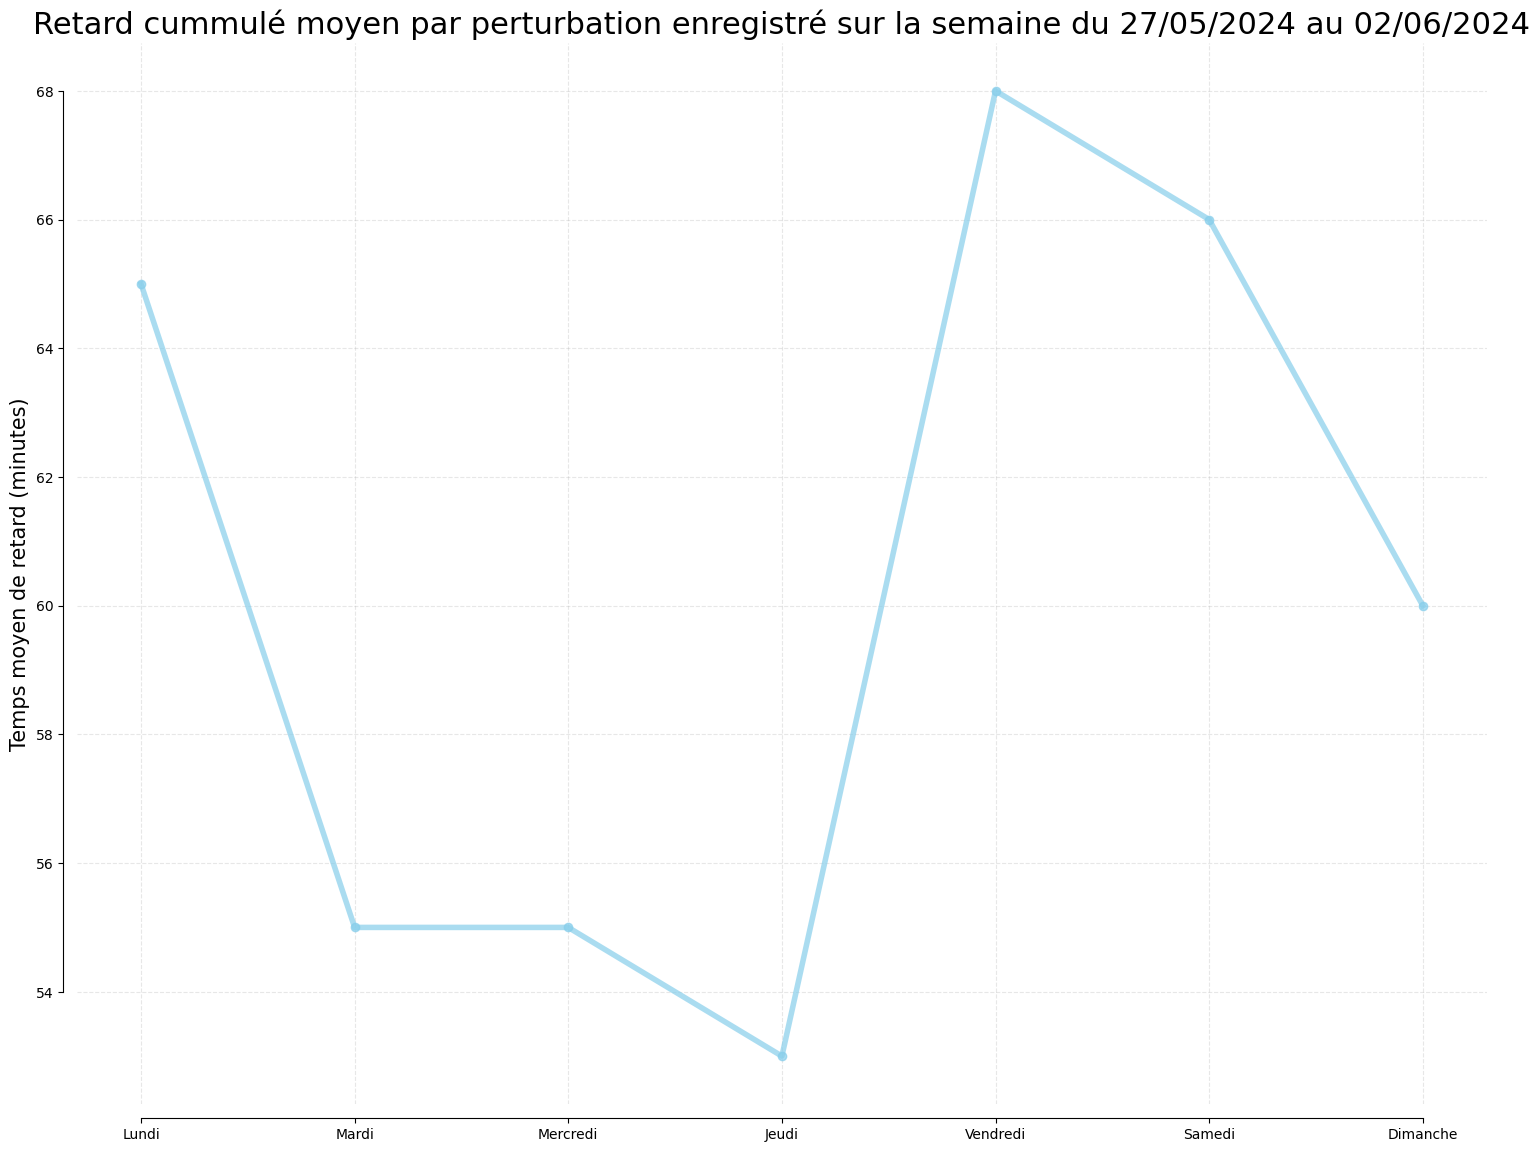

In [22]:
plt.figure(figsize=(15, 12))
plt.plot(mean_delay_by_disruption_daily.index, mean_delay_by_disruption_daily.values, color='skyblue', alpha=0.7, lw=4, marker='o', markersize=6)

plt.title(f'Retard cummulé moyen par perturbation enregistré sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Temps moyen de retard (minutes)', fontsize=15)
plt.xticks(nb_disruption_daily.index, days_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

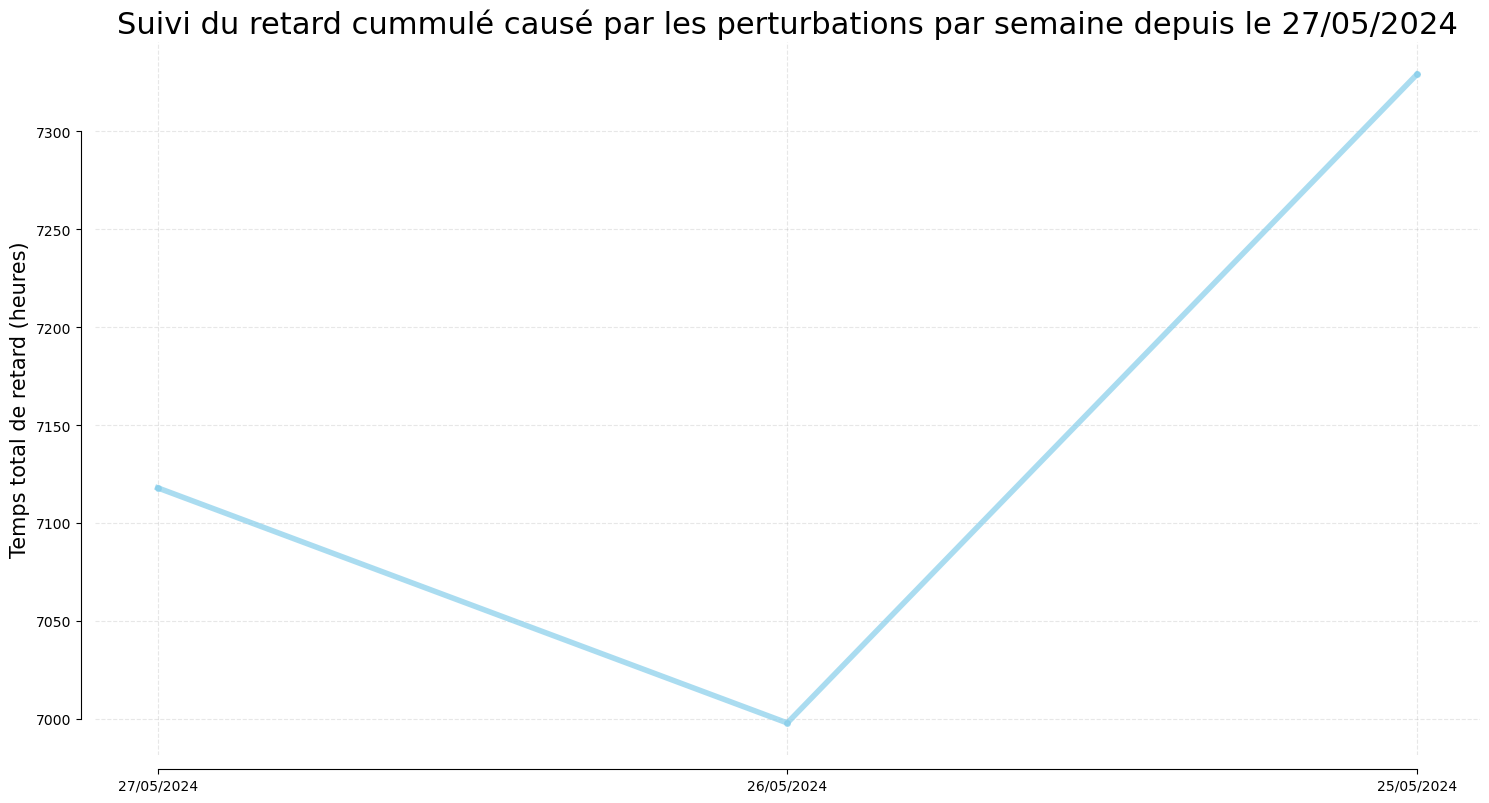

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(df_past['data_date'], df_past['total_delay'], color='skyblue', lw=4, alpha=0.7, marker='o', markersize=4)

plt.title(f'Suivi du retard cummulé causé par les perturbations par semaine depuis le {first_data_date}', fontsize=22)
plt.ylabel('Temps total de retard (heures)', fontsize=15)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)


plt.show()

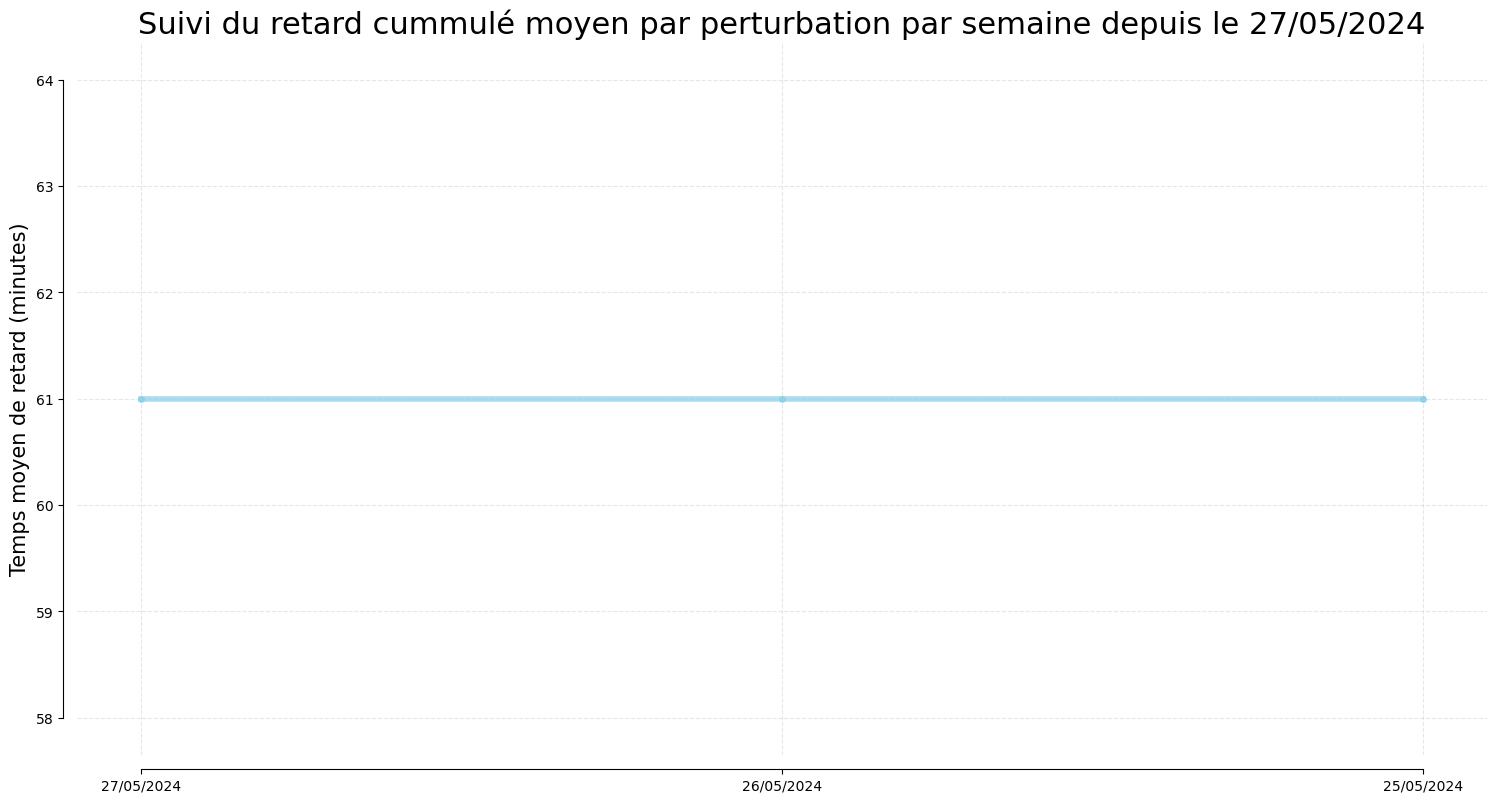

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(df_past['data_date'], round(df_past['total_delay']/df_past['nb_disruption']*60), color='skyblue', lw=4, alpha=0.7, marker='o', markersize=4)

plt.title(f'Suivi du retard cummulé moyen par perturbation par semaine depuis le {first_data_date}', fontsize=22)
plt.ylabel('Temps moyen de retard (minutes)', fontsize=15)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

Ces graphiques fournissent un indice clé de l'impact des perturbations sur le réseau en permettant une analyse dynamique de l'évolution du temps moyen de retard causé par ces perturbations, ainsi que du retard cumulé total sur l'ensemble du réseau. En observant ces données au fil du temps, il devient possible de suivre l'évolution de l'impact des perturbations. Cette surveillance permet d'évaluer l'efficacité des mesures prises pour atténuer ces perturbations et améliorer la fiabilité du système.

# 

# 

# ANALYSE DETAILLEE DES PERTURBATION

### NOMBRE DE PERTURBATION PAR RESEAU ET RETARD MOYEN

In [25]:
# Calcul du nombre de trajets de chaque réseau 
vehicle_by_network = df_merge.groupby('network_name')['vehicle_id'].count()

# Calcul du nombre de trajets perturbé par réseau
disrupted_vehicle_by_network = df_merge[df_merge['id_disruption'].notna()].groupby('network_name')['vehicle_id'].count()

# Gestion du cas (pas si rare que ca) où aucun trajet du réseau n'a été perturbé
for name in vehicle_by_network.index:
    if not(name in disrupted_vehicle_by_network.index):
        disrupted_vehicle_by_network[name] = 0

In [26]:
# Calcul du pourcentage de perturbation pour chaque réseau
per_disrupted_vehicle_by_network = (disrupted_vehicle_by_network/vehicle_by_network *100).where(disrupted_vehicle_by_network >= 1, 0).sort_values(ascending=True)
#en faire un tableau


# Calcul du retard total (à l'arrivée des gares) pour chaque réseau
total_delay_by_network = df_merge.groupby('network_name')['arrival_delay'].sum()

# Calcul du retard moyen par train pour chaque réseau
avg_delay_by_network = total_delay_by_network/vehicle_by_network

for i in range(len(disrupted_vehicle_by_network)):
    if not(disrupted_vehicle_by_network.index[i] in total_delay_by_network.index) : 
        avg_delay_by_network[i] = 0
        
# Conversion en string indicant les retards moyens en seconde
for i in range(len(avg_delay_by_network)):
    if avg_delay_by_network[i] != 0:
        avg_delay_by_network[i] = str(int(avg_delay_by_network[i]*60)) + " secondes" 
    else : 
        avg_delay_by_network[i] = "0 seconde"
# en faire un tableau

In [27]:
info_current = [vehicle_by_network, disrupted_vehicle_by_network, avg_delay_by_network]
info_name = ["Nombre de trajet", "Nombre de trajet \n perturbé", "Retard moyen \n par train"] 

def update_graph(selected_bar, selected_bar_past, selected_date):
    fig_network, axs = plt.subplots(2, 1, figsize=(13, 16))
    fig_network.subplots_adjust(hspace=10)
    
    index = df_past[df_past['data_date'] == selected_date].index
    value_string = df_past[df_past['data_date'] == selected_date]['per_disrupted_vehicle_by_network'][index[0]]
    value_dict = ast.literal_eval(value_string)
    per_disrupted_vehicle_by_network_past = pd.Series(value_dict)
    
    vehicle_by_network_past =  pd.Series(ast.literal_eval(df_past['vehicle_by_network'][index[0]]))
    disrupted_vehicle_by_network_past =  pd.Series(ast.literal_eval(df_past['disrupted_vehicle_by_network'][index[0]]))
    avg_delay_by_network_past =  pd.Series(ast.literal_eval(df_past['avg_delay_by_network'][index[0]]))
    info_past = [vehicle_by_network_past, disrupted_vehicle_by_network_past, avg_delay_by_network_past]
    
    if selected_bar == 'Partie 1':
        per_disrupted_vehicle_by_network_graph = per_disrupted_vehicle_by_network.iloc[8:]
        colors = ['darkblue', "#CD7F32", "#C0C0C0", "#FFD700"]
    elif selected_bar == 'Partie 2':
        per_disrupted_vehicle_by_network_graph = per_disrupted_vehicle_by_network.iloc[4:8]
        colors = ["darkblue", "darkblue", "darkblue", "darkblue"]
    elif selected_bar == 'Partie 3':
        per_disrupted_vehicle_by_network_graph = per_disrupted_vehicle_by_network.iloc[:4]
        colors = ["skyblue", "skyblue", "darkblue", 'darkblue']
    
    if selected_bar_past == 'Partie 1_past':
        per_disrupted_vehicle_by_network_past_graph = per_disrupted_vehicle_by_network_past.iloc[8:]
        past_colors = ['darkblue', "#CD7F32", "#C0C0C0", "#FFD700"]
    elif selected_bar_past == 'Partie 2_past':
        per_disrupted_vehicle_by_network_past_graph = per_disrupted_vehicle_by_network_past.iloc[4:8]
        past_colors = ["darkblue", "darkblue", "darkblue", 'darkblue']
    elif selected_bar_past == 'Partie 3_past':
        per_disrupted_vehicle_by_network_past_graph = per_disrupted_vehicle_by_network_past.iloc[:4]
        past_colors = ["skyblue", "skyblue", "darkblue", 'darkblue']

    
    transformation_current = (per_disrupted_vehicle_by_network_graph + 20) * 0.1
    transformation_past = (per_disrupted_vehicle_by_network_past_graph + 20) * 0.1

    for ax, values, colors, transformation, info, selected_date in zip(axs, [per_disrupted_vehicle_by_network_graph, per_disrupted_vehicle_by_network_past_graph], [colors, past_colors], [transformation_current, transformation_past], [info_current, info_past], [week_start, selected_date]):
        bars = ax.barh(transformation.index, transformation, color=colors, height=0.03)

        x_positions = transformation + 0.1
        ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=5000)

        intervals_white = [2/8, 4/8, 6/8]
        intervals_black = [1/8, 3/8, 5/8, 7/8]

        for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
            y = bar.get_y() + bar.get_height() / 2
            ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=16, fontweight='bold')
            ax.text(0, y + bar.get_height() + 0.4, values.index[j], fontsize=16, fontweight='bold')

            for i, interval in enumerate(intervals_white):
                circle_x = bar.get_width() * interval
                ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=400)
                ax.vlines(circle_x, y - 0.085, y - 0.175, colors='black', linewidth=1)
                current_info_value = info[i][transformation.index[j]]
                ax.text(circle_x, y - 0.225, f'{current_info_value}', ha='center', va='top', fontsize=13, fontweight='bold')
                if j == 3:
                    ax.text(circle_x + 0.25, y + 0.1, info_name[i], ha='center', va='bottom', fontsize=13, rotation=45)

            for interval in intervals_black:
                circle_x = bar.get_width() * interval
                ax.scatter(circle_x, y, facecolors=colors[j], s=300)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
        ax.set_ylim(bottom=ax.get_ylim()[0] - 0.25, top=ax.get_ylim()[1] + 0.5)
        ax.set_title(f'Informations sur les perturbations par réseau pour la semaine du {selected_date}', fontsize=20, pad=50)

    plt.tight_layout()
    plt.show()

button_style = {'button_width': '300px', 'button_height': '100px'}

widget_buttons = widgets.ToggleButtons(
    options=["Partie 1", "Partie 2", "Partie 3"],
    description='',  
    disabled=False,
    style=button_style
)

widget_buttons_past = widgets.ToggleButtons(
    options=["Partie 1_past", "Partie 2_past", "Partie 3_past"],
    description='',  
    disabled=False,
    style=button_style
)


date_options = df_past['data_date']
widget_date = widgets.Dropdown(
    options=date_options,
    value=date_options[0],
    description='Date:',
    disabled=False,
)

widget_buttons_past_box = HBox([widget_buttons_past, widget_date])
HBox([widget_buttons, widget_buttons_past_box])
interact(update_graph, selected_bar=widget_buttons, selected_bar_past=widget_buttons_past,  selected_date=widget_date)

interactive(children=(ToggleButtons(description='selected_bar', options=('Partie 1', 'Partie 2', 'Partie 3'), …

<function __main__.update_graph(selected_bar, selected_bar_past, selected_date)>

# 

### ROUTES LES PLUS PERTURBEES ET CAUSES ASSOCIEES

In [28]:
# Nombre de trajet par route
vehicle_by_route = df_merge.groupby('route_name')['vehicle_id'].count()

# Nombre de perturbation par route
disruption_by_route = df_merge.groupby('route_name')['id_disruption'].count()

# Pourcentage de trajet perturbé par route
per_disruption_by_route = disruption_by_route/vehicle_by_route*100
per_disruption_by_route = per_disruption_by_route.replace([np.inf, -np.inf], 0).dropna()

print(per_disruption_by_route)

route_name
(Namur) - (Charleroi) - Maubeuge                            6.557377
11. Poitiers-Tours                                         13.888889
21. Châteauroux - La Souterraine - Limoges                  7.142857
Alençon - Château Du Loir                                   5.633803
Alençon - Le Mans - Tours                                  16.216216
                                                             ...    
Valenciennes - Paris Nord                                  30.769231
Villefranche Vernet Les Bains - Latour De Carol Enveitg     0.000000
Villefranche Vernet Les Bains - Perpignan                  19.444444
Wissembourg - Neustadt                                      9.708738
YVETOT - ROUEN - ELBEUF                                     3.888889
Length: 368, dtype: float64


In [29]:
# cela montre où les différents groupe de perturbation arrive --> pourrait servir pour comprendre ou il faut investir 
cause_group_by_route = df_merge.groupby(['group_delay', 'route_name'])['cause_delay'].count()
print(cause_group_by_route)

group_delay                                            route_name                                   
Dérangement d'un équipement technique ou informatique  D44                                              1
                                                       Laval - Le Mans                                  1
                                                       Nîmes-Avignon-Le Teil                            1
                                                       Reims - Paris Est                                1
                                                       Saint-Marcellin - Grenoble Universités Gières    1
                                                                                                       ..
problemes techniques                                   Tours - Lyon                                     1
                                                       Tours - Poitiers                                 1
                                                   

In [30]:
cause_by_route = df_merge.groupby(['cause_delay', 'route_name'])['cause_delay'].count()
print(cause_by_route)

cause_delay            route_name                                 
Accident de personne   Brest - Paris - Montparnasse - Hall 1 & 2      1
                       C41                                            1
                       CAEN- COUTANCES - GRANVILLE - RENNES           1
                       Dijon - Laroche - Auxerre                      1
                       Dijon-Besançon                                 7
                                                                     ..
Travaux sur les voies  Rennes - Marseille Saint-Charles               1
                       Rennes - St-Brieuc                             1
                       Toulouse Matabiau - Montauban Ville Bourbon    1
                       Toulouse Matabiau - Paris Austerlitz           1
                       Valence - Avignon - Marseille                  2
Name: cause_delay, Length: 1296, dtype: int64


# 

### ARRETS LES PLUS IMPACTES ET CAUSES ASSOCIEES

In [31]:
# Mettre en pourcentage de frequentation ? de vehicule qui passe ? 
most_impacted_stop = df_merge.groupby('name_stop')['id_disruption'].count().sort_values(ascending=False)
print(most_impacted_stop)

name_stop
Paris - Gare de Lyon - Hall 1 & 2    262
Marseille Saint-Charles              211
Lille Flandres                       156
Strasbourg                           142
Lyon Part Dieu                       127
                                    ... 
Commercy                               1
Corbigny                               1
Pauillac                               1
Courtalain - Saint-Pellerin            1
Rang-du-Fliers - Verton - Berck        1
Name: id_disruption, Length: 347, dtype: int64


In [32]:
cause_group_by_stop = df_merge.groupby(['group_delay', 'name_stop'])['cause_delay'].count()
print(cause_group_by_stop)

group_delay                                               name_stop           
Choc nécessitant une vérification technique sur le train  Annemasse               1
                                                          Beauvais                1
                                                          Évian-les-Bains         1
Dérangement d'un équipement technique ou informatique     Agen                    2
                                                          Annecy                  1
                                                                                 ..
problemes techniques                                      Villars-les-Dombes      1
                                                          Volvic                  1
                                                          Étang                   1
                                                          Étaples - Le Touquet    1
                                                          Évian-les-Bains        

In [33]:
cause_by_stop = df_merge.groupby(['cause_delay', 'name_stop'])['cause_delay'].count()
print(cause_by_stop)

cause_delay            name_stop           
Accident de personne   Besançon-Viotte         5
                       Caen                    1
                       Culmont - Chalindrey    1
                       Dijon                   6
                       Is-sur-Tille            3
                                              ..
Travaux sur les voies  Strasbourg              1
                       Tassin                  2
                       Toulouse Matabiau       2
                       Valence Ville           2
                       Vienne                  1
Name: cause_delay, Length: 1449, dtype: int64


# 

# 

#  ANALYSE TEMPORELLE DES PERTURBATION

### NOMBRE DE PERTURBATION AU FIL DE LA JOURNEE

In [34]:
start_time = datetime(2023, 1, 1, 0, 0) 
end_time = datetime(2023, 1, 2, 0, 0)  

ten_intervals = []
current_time = start_time
while current_time < end_time:
    ten_intervals.append(current_time.time())
    current_time += timedelta(minutes=10)
    
def disruption_across_day(df):
    start = [t.time() for t in df['disruption_start']]
    end = [t.time() for t in df['disruption_end']]
        
    disrupiton_by_ten = []

    for time in ten_intervals:
        nb_disruption = 0
        for i in range(len(start)):
            if time > start[i] and time < end[i]:
                nb_disruption += 1 
        disrupiton_by_ten.append(nb_disruption)
        
    return disrupiton_by_ten

disruption_by_ten = disruption_across_day(df_disruption_unique)

In [35]:
hours_intervals_name = []
count=0

for t in range(0,len(ten_intervals)):
    if count == 12 :
        hours_intervals_name.append(str(ten_intervals[t])[:5])
        count=0
    else :
        hours_intervals_name.append('')
    count+= 1

hours_intervals_name[0] = '00:00'
hours_intervals_name[-1] = '23:59'

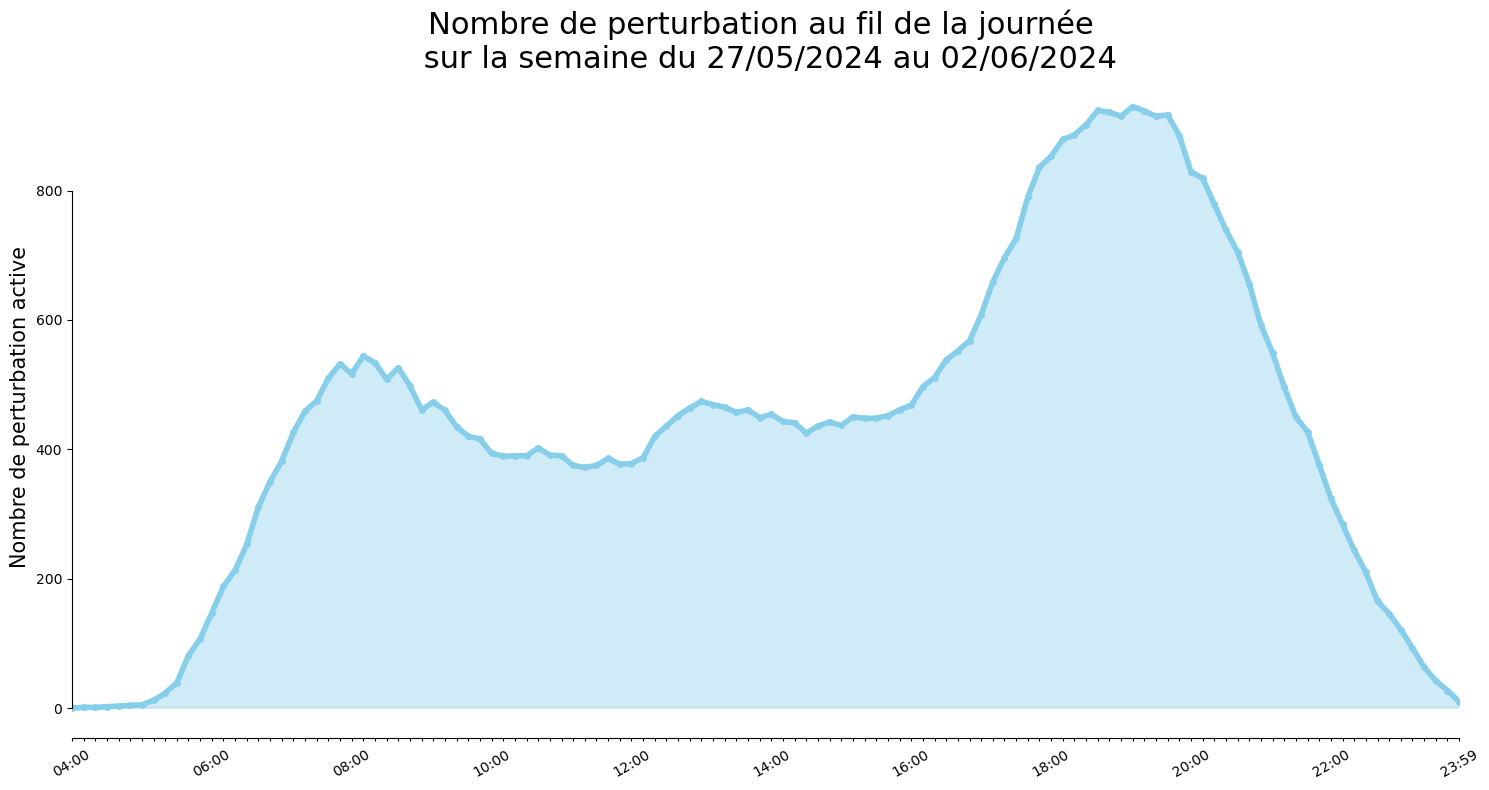

In [36]:
plt.figure(figsize=(15, 8))

plt.plot(range(len(disruption_by_ten)), disruption_by_ten, c='skyblue', lw=4, marker='o', markersize=4)
plt.fill_between(range(len(disruption_by_ten)), disruption_by_ten, color='skyblue', alpha=0.4)

plt.title(f'Nombre de perturbation au fil de la journée \n sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de perturbation active', fontsize=15)
plt.xticks(range(len(disruption_by_ten)), hours_intervals_name, rotation=30, fontsize=10)
plt.tick_params(axis='x', which='both', length=2, pad=5)
plt.xlim(24, len(disruption_by_ten) - 1)

plt.tight_layout()
sns.despine(trim=True)

plt.show()

# 

### NOMBRE DE PERTURBATIONS PAR TYPE DE PERTURBATION AU FIL DE LA JOURNEE

In [37]:
df_disruption_incivilite = df_disruption_unique[df_disruption_unique['cause_delay'].isin(incivilite)]
disruption_by_ten_incivilite = disruption_across_day(df_disruption_incivilite)

df_disruption_problemes_techniques = df_disruption_unique[df_disruption_unique['cause_delay'].isin(problemes_techniques)]
disruption_by_ten_problemes_techniques = disruption_across_day(df_disruption_problemes_techniques)

df_disruption_conditions_operationnelles = df_disruption_unique[df_disruption_unique['cause_delay'].isin(conditions_operationnelles)]
disruption_by_ten_conditions_operationnelles = disruption_across_day(df_disruption_conditions_operationnelles)

df_disruption_conditions_externes = df_disruption_unique[df_disruption_unique['cause_delay'].isin(conditions_externes)]
disruption_by_ten_conditions_externes = disruption_across_day(df_disruption_conditions_externes)

df_disruption_assistance_passagers = df_disruption_unique[df_disruption_unique['cause_delay'].isin(assistance_passagers)]
disruption_by_ten_assistance_passagers = disruption_across_day(df_disruption_assistance_passagers)

df_disruption_non_specifie = df_disruption_unique[df_disruption_unique['cause_delay'] == 'Non connu' ]
disruption_by_ten_non_specifie = disruption_across_day(df_disruption_non_specifie)

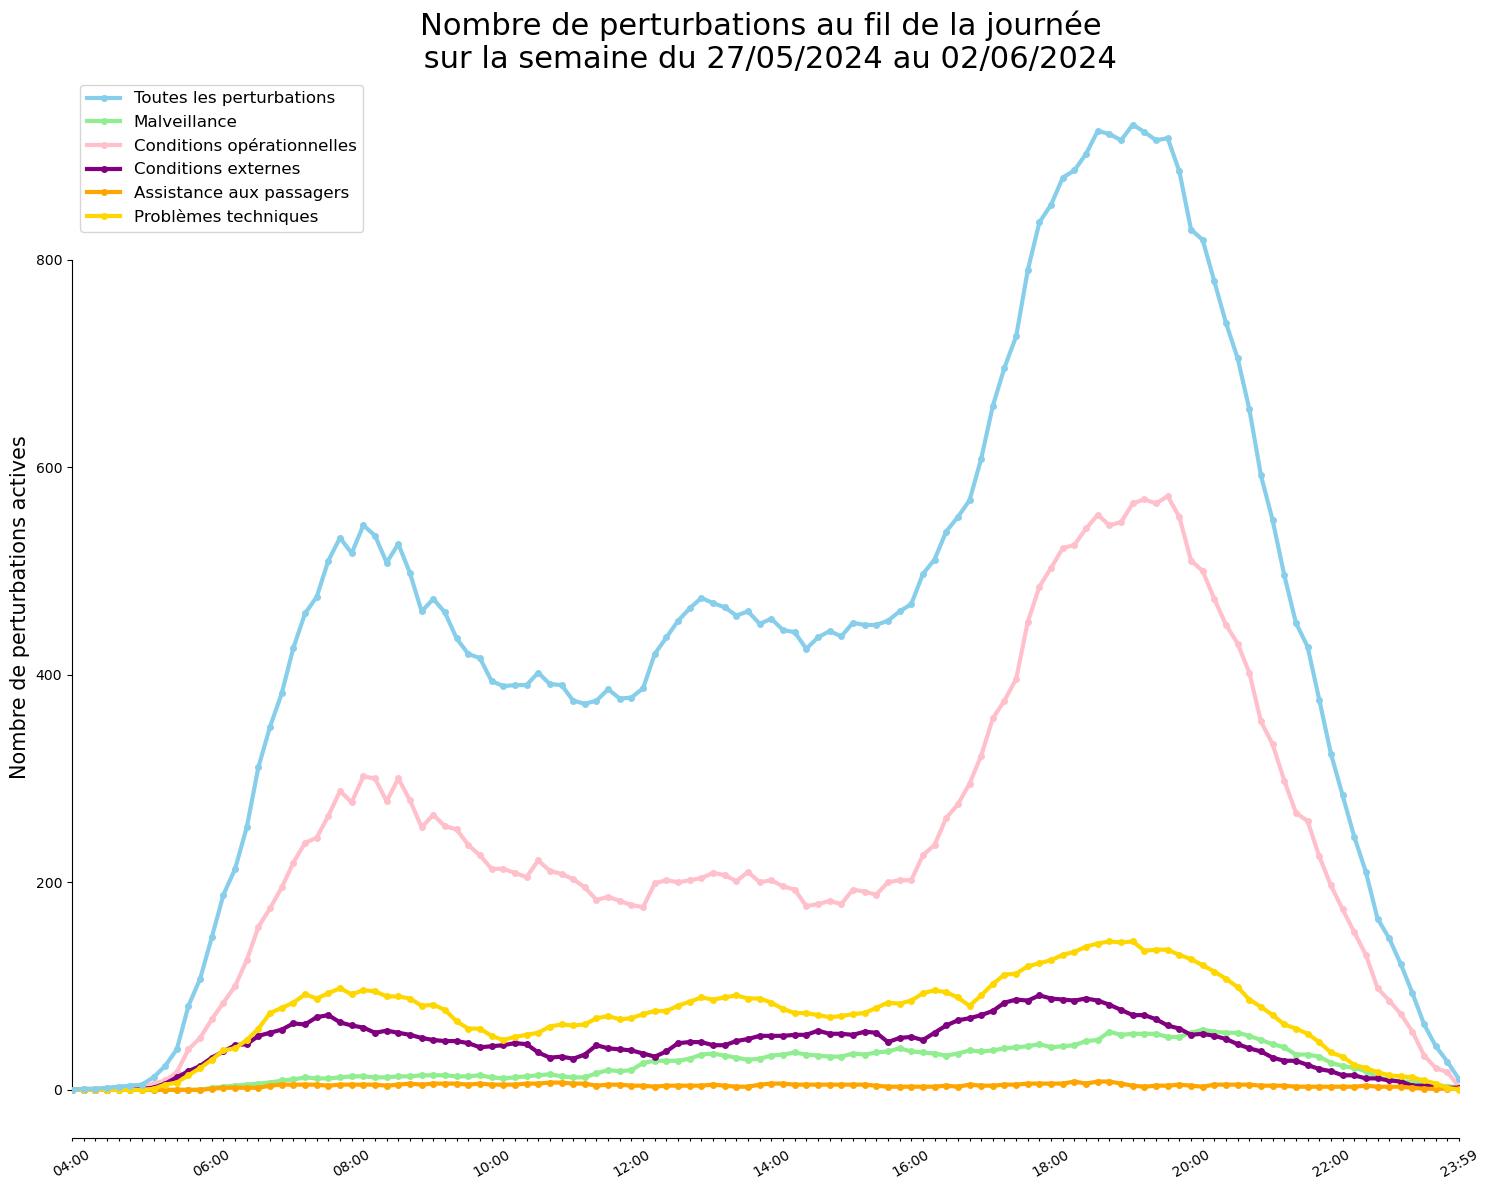

In [38]:
plt.figure(figsize=(15, 12))

plt.plot(range(len(disruption_by_ten)), disruption_by_ten, c='skyblue', lw=3, marker='o', markersize=4, label='Toutes les perturbations', zorder=10)
plt.plot(range(len(disruption_by_ten_incivilite)), disruption_by_ten_incivilite, c='lightgreen', lw=3, marker='o', markersize=4, label='Malveillance')
plt.plot(range(len(disruption_by_ten_conditions_operationnelles)), disruption_by_ten_conditions_operationnelles, c='pink', lw=3, marker='o', markersize=4, label='Conditions opérationnelles')
plt.plot(range(len(disruption_by_ten_conditions_externes)), disruption_by_ten_conditions_externes, c='purple', lw=3, marker='o', markersize=4, label='Conditions externes')
plt.plot(range(len(disruption_by_ten_assistance_passagers)), disruption_by_ten_assistance_passagers, c='orange', lw=3, marker='o', markersize=4, label='Assistance aux passagers')
plt.plot(range(len(disruption_by_ten_problemes_techniques)), disruption_by_ten_problemes_techniques, c='gold', lw=3, marker='o', markersize=4, label='Problèmes techniques')

plt.title(f'Nombre de perturbations au fil de la journée \n sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de perturbations actives', fontsize=15)
plt.xticks(range(len(disruption_by_ten)), hours_intervals_name, rotation=30, fontsize=10)
plt.tick_params(axis='x', which='both', length=2, pad=5)
plt.xlim(24, len(disruption_by_ten) - 1)

plt.legend(fontsize=12)

plt.tight_layout()
sns.despine(trim=True)

plt.show()

# 

### CAUSES DES PERTURBATIONS SUR LA SEMAINE ET RETARD CAUSE PAR CES CAUSES

In [39]:
cause_delay_count = df_disruption_unique.groupby(['group_delay', 'cause_delay'])['cause_delay'].count()
print(cause_delay_count)

cause_delay_count_group_daily = df_disruption_unique.groupby(['data_date', 'group_delay'])['cause_delay'].count()
print(cause_delay_count_group_daily)

group_delay                                               cause_delay                                             
Choc nécessitant une vérification technique sur le train  Choc nécessitant une vérification technique sur le train       3
Dérangement d'un équipement technique ou informatique     Dérangement d'un équipement technique ou informatique         17
Embouteillage                                             Embouteillage                                                  1
Heurt d'un animal                                         Heurt d'un animal                                             13
Incident technique sur la voie                            Incident technique sur la voie                                 9
Non connu                                                 Non connu                                                    375
Présence de manifestants sur les voies                    Présence de manifestants sur les voies                         4
assistance passagers    

In [40]:
delay_by_cause = df_disruption_unique.groupby(['group_delay', 'cause_delay'])['arrival_delay'].sum()
print(delay_by_cause)

group_delay                                               cause_delay                                             
Choc nécessitant une vérification technique sur le train  Choc nécessitant une vérification technique sur le train      45.0
Dérangement d'un équipement technique ou informatique     Dérangement d'un équipement technique ou informatique        170.0
Embouteillage                                             Embouteillage                                                  5.0
Heurt d'un animal                                         Heurt d'un animal                                             85.0
Incident technique sur la voie                            Incident technique sur la voie                                 0.0
Non connu                                                 Non connu                                                    155.0
Présence de manifestants sur les voies                    Présence de manifestants sur les voies                        15.0
assistance

In [41]:
delay_by_cause_group_daily = df_disruption_unique.groupby(['data_date','group_delay'])['arrival_delay'].sum()
print(delay_by_cause_group_daily)

data_date   group_delay                                             
01/06/2024  Non connu                                                      5.0
            Présence de manifestants sur les voies                         0.0
            assistance passagers                                          40.0
            conditions externes                                          215.0
            conditions operationnelles                                  1505.0
            incivilite                                                   145.0
            problemes techniques                                         410.0
02/06/2024  Incident technique sur la voie                                 0.0
            Non connu                                                      0.0
            assistance passagers                                          25.0
            conditions externes                                           35.0
            conditions operationnelles                        

# 

### FREQUENTATION

# 

# 

# SAUVEGARDE DES RESULTATS

In [360]:
total_delay_daily = [total_delay_daily.to_dict()]
mean_time_disruption_minutes_daily = [mean_time_disruption_minutes_daily.to_dict()]
nb_disruption_daily = [nb_disruption_daily.to_dict()]
nb_vehicle_journeys_daily = [nb_vehicle_journeys_daily.to_dict()]
per_disrupted_daily = [per_disrupted_daily.to_dict()]
vehicle_by_network = [vehicle_by_network.to_dict()]
disrupted_vehicle_by_network= [disrupted_vehicle_by_network.to_dict()]
per_disrupted_vehicle_by_network = [per_disrupted_vehicle_by_network.to_dict()]
avg_delay_by_network = [avg_delay_by_network.to_dict()]
vehicle_by_route = [vehicle_by_route.to_dict()]
disruption_by_route = [disruption_by_route.to_dict()]
per_disruption_by_route = [per_disruption_by_route.to_dict()]
cause_group_by_route = [cause_group_by_route.to_dict()]
cause_by_route = [cause_by_route.to_dict()]
most_impacted_stop = [most_impacted_stop.to_dict()]
cause_group_by_stop = [cause_group_by_stop.to_dict()]
cause_by_stop = [cause_by_stop.to_dict()]
cause_delay_count = [cause_delay_count.to_dict()]
delay_by_cause = [delay_by_cause.to_dict()]
disrupiton_by_ten = [disrupiton_by_ten]
disrupiton_by_ten_incivilite = [disrupiton_by_ten_incivilite]
disruption_by_ten_problemes_techniques = [disruption_by_ten_problemes_techniques]
disruption_by_ten_conditions_operationnelles = [disruption_by_ten_conditions_operationnelles]
disruption_by_ten_conditions_externes = [disruption_by_ten_conditions_externes]
disruption_by_ten_assistance_passagers = [disruption_by_ten_assistance_passagers]
disruption_by_ten_non_specifie = [disruption_by_ten_non_specifie]

In [361]:
dict_temporelle = {'nb_disruption':nb_disruption,
                   'nb_vehicle_journeys':nb_vehicle_journeys,
                   'per_disrupted':per_disrupted,
                   'nb_disruption_daily':nb_disruption_daily,
                   'nb_vehicle_journeys_daily':nb_vehicle_journeys_daily,
                   'per_disrupted_daily': per_disrupted_daily,
                   'mean_time_disruption_minutes':mean_time_disruption_minutes,
                   'mean_time_disruption_minutes_daily': mean_time_disruption_minutes_daily,
                   'total_delay':total_delay,
                   'total_delay_daily': total_delay_daily,
                   'mean_delay_by_disruption':total_delay/nb_disruption*60,
                   'vehicle_by_network': vehicle_by_network,
                   'disrupted_vehicle_by_network':disrupted_vehicle_by_network,
                   'per_disrupted_vehicle_by_network':per_disrupted_vehicle_by_network,
                   'avg_delay_by_network':avg_delay_by_network,
                   'vehicle_by_route':vehicle_by_route,
                   'disruption_by_route':disruption_by_route,
                   'per_disruption_by_route':per_disruption_by_route,
                   'cause_group_by_route':cause_group_by_route,
                   'cause_by_route':cause_by_route,
                   'most_impacted_stop':most_impacted_stop,
                   'cause_group_by_stop':cause_group_by_stop,
                   'cause_by_stop':cause_by_stop,
                   'cause_delay_count':cause_delay_count,
                   'delay_by_cause':delay_by_cause,
                   'disrupiton_by_ten': disrupiton_by_ten,
                   'disrupiton_by_ten_incivilite': disrupiton_by_ten_incivilite,
                   'disruption_by_ten_problemes_techniques':disruption_by_ten_problemes_techniques,
                   'disruption_by_ten_conditions_operationnelles':disruption_by_ten_conditions_operationnelles,
                   'disruption_by_ten_conditions_externes':disruption_by_ten_conditions_externes,
                   'disruption_by_ten_assistance_passagers':disruption_by_ten_assistance_passagers,
                   'disruption_by_ten_non_specifie':disruption_by_ten_non_specifie,
                   'data_date':week_start                   
}

In [362]:
df_temporelle = pd.DataFrame(dict_temporelle)
df_temporelle.to_csv('Resultats_rapport_2.csv', mode='a', header=False, index=False)